# Gibbs sampling in Edward

## Boilerplate

In [2]:
import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import Empirical, Beta, Bernoulli

In [18]:
# Adapted from https://stackoverflow.com/questions/38189119
from IPython.display import clear_output, Image, display, HTML

def strip_consts(graph_def, max_const_size=32):
    """Strip large constant values from graph_def."""
    strip_def = tf.GraphDef()
    for n0 in graph_def.node:
        n = strip_def.node.add() 
        n.MergeFrom(n0)
        if n.op == 'Const':
            tensor = n.attr['value'].tensor
            size = len(tensor.tensor_content)
            if size > max_const_size:
                tensor.tensor_content = "<stripped %d bytes>"%size
    return strip_def

def show_graph(graph_def, max_const_size=32):
    """Visualize TensorFlow graph."""
    if hasattr(graph_def, 'as_graph_def'):
        graph_def = graph_def.as_graph_def()
    strip_def = strip_consts(graph_def, max_const_size=max_const_size)
    code = """
        <script>
          function load() {{
            document.getElementById("{id}").pbtxt = {data};
          }}
        </script>
        <link rel="import" href="https://tensorboard.appspot.com/tf-graph-basic.build.html" onload=load()>
        <div style="height:600px">
          <tf-graph-basic id="{id}"></tf-graph-basic>
        </div>
    """.format(data=repr(str(strip_def)), id='graph'+str(np.random.rand()))

    iframe = """
        <iframe seamless style="width:1200px;height:620px;border:0" srcdoc="{}"></iframe>
    """.format(code.replace('"', '&quot;'))
    display(HTML(iframe))

## A trivial Beta-Bernoulli model

In [15]:
x_data = np.array([0, 1, 0])

p = Beta(1.0, 1.0)
x = Bernoulli(probs=p, sample_shape=3)

qp = Empirical(tf.Variable(tf.zeros(10)))
inference = ed.Gibbs({p: qp}, data={x: x_data})

In [21]:
inference.run()

10/10 [100%] ██████████████████████████████ Elapsed: 0s | Acceptance Rate: 1.000


## Graph visualization

In [20]:
show_graph(tf.get_default_graph().as_graph_def())

In [22]:
help(ed.complete_conditional)

Help on function complete_conditional in module edward.inferences.conjugacy.conjugacy:

complete_conditional(rv, cond_set=None)
    Returns the conditional distribution `RandomVariable` p(`rv` | .).
    
    This function tries to infer the conditional distribution of `rv`
    given `cond_set`, a set of other `RandomVariable`s in the graph. It
    will only be able to do this if
    a) p(`rv` | `cond_set`) is in a tractable exponential family AND
    b) the truth of assumption (a) is not obscured in the TensorFlow graph.
    In other words, this function will do its best to recognize conjugate
    relationships when they exist, but it may not always be able to do the
    necessary algebra.
    
    Parameters
    ----------
    rv : RandomVariable
      The `RandomVariable` whose conditional distribution we are interested in.
    cond_set : iterable of RandomVariables, optional
      The set of `RandomVariable`s we want to condition on. Defaults to all
      `RandomVariable`s in the gr

## A Normal-Normal model

Edward uses the default session for scratchwork (to store graph components).
To clean up the graph, you should restart the kernel.

In [30]:
import numpy as np
import tensorflow as tf
import edward as ed
from edward.models import Normal
sess = ed.get_session()

In [31]:
x = Normal(0.0, 1.0)
y = Normal(x, 1.0)
z = Normal(y, 1.0)

In [32]:
z_obs = 0.5  # Observe
x_est, y_est = sess.run([x, y])  # Initialiize randomly
x_est, y_est

(0.35840517, 0.27275681)

In [33]:
x_cond = ed.complete_conditional(x)
y_cond = ed.complete_conditional(y)

In [34]:
T = 1000
xy = np.zeros([2, T])
for t in range(T):
    x_est = sess.run(x_cond, {y: y_est})
    y_est = sess.run(y_cond, {x: x_est, z: z_obs})
    xy[0][t] = x_est
    xy[1][t] = y_est

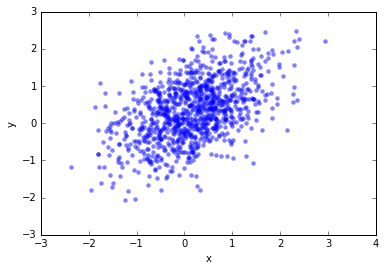

In [35]:
%matplotlib inline
from matplotlib import pyplot
pyplot.scatter(xy[0], xy[1], lw=0, alpha=0.5)
pyplot.xlabel('x')
pyplot.ylabel('y')

In [19]:
show_graph(tf.get_default_graph().as_graph_def())